In [1]:
import os
import sys

main_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
sys.path.append(main_dir)

print("Main directory added to sys.path:", main_dir)

Main directory added to sys.path: /data/inr/llm


In [2]:
DATASET_DIR = os.path.join(
    main_dir, "Datasets","LOVEDA", "Train", "Train"
)

In [3]:
from collections import OrderedDict

COLOR_MAP_LOVEDA = OrderedDict(
    Background=(255, 255, 255),
    Building=(255, 0, 0),
    Road=(255, 255, 0),
    Water=(0, 0, 255),
    Barren=(159, 129, 183),
    Forest=(0, 255, 0),
    Agricultural=(255, 195, 128),
)

LABEL_MAP_LOVEDA = OrderedDict(
    Background=0,
    Building=1,
    Road=2,
    Water=3,
    Barren=4,
    Forest=5,
    Agricultural=6
)

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

MASK1 = os.path.join(DATASET_DIR,"Rural","masks_png", "134.png")

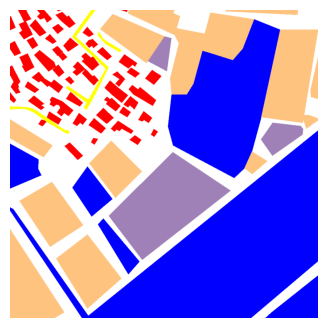

In [5]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Colors (same as you provided)
COLORS = {
    "Background": (255, 255, 255),
    "Building": (255, 0, 0),
    "Road": (255, 255, 0),
    "Water": (0, 0, 255),
    "Barren": (159, 129, 183),
    "Forest": (0, 255, 0),
    "Agricultural": (255, 195, 128),
}

def loveda_mask_to_rgb(mask_2d: np.ndarray) -> np.ndarray:
    """
    Works for:
    - Official LoveDA labels: 0=NoData(ignore), 1..7=classes
    - Reduced labels (common): 0..6=classes, 255=ignore
    """
    if mask_2d.ndim != 2:
        raise ValueError(f"Expected (H,W) mask, got shape {mask_2d.shape}")

    # LUT for 0..255
    lut = np.zeros((256, 3), dtype=np.uint8)

    # Make NO-DATA / IGNORE white
    lut[0]   = (255, 255, 255)   # official no-data
    lut[255] = (255, 255, 255)   # ignore_index variant

    u = np.unique(mask_2d)

    if u.max() <= 7:
        # Official LoveDA: background=1, building=2, ..., agriculture=7
        lut[1] = COLORS["Background"]
        lut[2] = COLORS["Building"]
        lut[3] = COLORS["Road"]
        lut[4] = COLORS["Water"]
        lut[5] = COLORS["Barren"]
        lut[6] = COLORS["Forest"]
        lut[7] = COLORS["Agricultural"]
    else:
        # Reduced labels: background=0, building=1, ..., agriculture=6; ignore often 255
        lut[0] = COLORS["Background"]
        lut[1] = COLORS["Building"]
        lut[2] = COLORS["Road"]
        lut[3] = COLORS["Water"]
        lut[4] = COLORS["Barren"]
        lut[5] = COLORS["Forest"]
        lut[6] = COLORS["Agricultural"]

    # Colorize
    return lut[mask_2d.astype(np.uint8)]

# Load mask safely as single-channel
mask_pil = Image.open(MASK1)
mask = np.array(mask_pil)
if mask.ndim == 3:
    # if someone saved it as RGB by mistake, take one channel or convert
    mask = np.array(mask_pil.convert("L"))

rgb = loveda_mask_to_rgb(mask)

plt.figure(figsize=(4, 4))
plt.imshow(rgb)
plt.axis("off")
# plt.title("LOVEDA Mask (RGB)")
plt.show()


In [6]:
from pathlib import Path
from typing import Dict, Tuple, Iterable, Optional
import numpy as np
from PIL import Image

try:
    import pandas as pd
except Exception:
    pd = None


def _iter_mask_files(mask_dir: Path) -> Iterable[Path]:
    # LoveDA usually stores masks in: <split>/<Rural|Urban>/masks_png/*.png
    # but we also support nested layouts by searching recursively.
    if not mask_dir.exists():
        return []
    direct = sorted(mask_dir.glob("*.png"))
    if len(direct) > 0:
        return direct
    return sorted(mask_dir.rglob("*.png"))


def _load_mask_as_2d(path: Path) -> np.ndarray:
    m = Image.open(path)
    arr = np.array(m)
    if arr.ndim == 2:
        return arr
    # If someone saved it as RGB/RGBA, convert to single-channel labels
    return np.array(m.convert("L"))


def _detect_loveda_convention(hist: np.ndarray) -> str:
    """Detect LoveDA label convention from a 256-bin histogram.

    Returns: "official" or "reduced"
      - official: 0=NoData(ignore), 1..7=classes
      - reduced: 0..6=classes, 255=ignore_index (common)

    Note: Presence of 255 should NOT imply official (it usually implies reduced).
    """
    if hist.shape[0] != 256:
        raise ValueError("Expected 256-bin histogram")

    has_255 = hist[255] > 0
    has_7 = hist[7] > 0
    max_nonzero = int(np.max(np.nonzero(hist)[0])) if hist.sum() > 0 else 0

    # Strong signals first
    if has_255 and not has_7:
        return "reduced"
    if has_7 and not has_255:
        return "official"
    if max_nonzero <= 6:
        return "reduced"
    if max_nonzero == 7:
        return "official"

    # Ambiguous / unexpected labels: fall back to reduced if 255 present, else official
    return "reduced" if has_255 else "official"


def compute_class_percentages_for_dir(
    mask_dir: Path,
    *,
    reduced_names: Optional[Tuple[str, ...]] = None,
    official_names: Optional[Tuple[str, ...]] = None,
    ignore_reduced: Tuple[int, ...] = (255,),
    ignore_official: Tuple[int, ...] = (0,),
    max_masks: Optional[int] = None,
    return_num_masks: bool = False,
    return_valid_pixels: bool = False,
):
    """
    Returns by default:
      - percentages: {class_name: percent_of_valid_pixels}
      - counts: {class_name: raw_pixel_count}

    Optionally also returns:
      - num_masks: number of mask images aggregated
      - valid_pixels: total valid pixels (after ignoring convention's ignore index)

    Automatically detects whether masks are in "official" (1..7 + 0=NoData)
    or "reduced" (0..6 + 255=ignore) label convention.
    """
    # Defaults aligned with your COLOR/LABEL map ordering
    if reduced_names is None:
        reduced_names = (
            "Background", "Building", "Road", "Water", "Barren", "Forest", "Agricultural"
        )
    if official_names is None:
        official_names = (
            "Background", "Building", "Road", "Water", "Barren", "Forest", "Agricultural"
        )

    files = list(_iter_mask_files(mask_dir))
    if max_masks is not None:
        files = files[:max_masks]
    if len(files) == 0:
        raise FileNotFoundError(f"No .png masks found under: {mask_dir}")

    hist = np.zeros(256, dtype=np.int64)
    for p in files:
        mask = _load_mask_as_2d(p)
        # Robust bincount over uint8 range
        m = mask.astype(np.uint8, copy=False).ravel()
        hist += np.bincount(m, minlength=256)

    # Detect convention (robust to ignore=255)
    convention = _detect_loveda_convention(hist)
    if convention == "official":
        class_ids = list(range(1, 8))
        class_names = official_names
        ignore_vals = set(ignore_official)
    else:
        class_ids = list(range(0, 7))
        class_names = reduced_names
        ignore_vals = set(ignore_reduced)

    # Build valid pixel total (exclude ignore indices for the chosen convention)
    total_pixels = int(hist.sum())
    ignore_pixels = int(sum(hist[v] for v in ignore_vals if 0 <= v <= 255))
    valid_pixels = total_pixels - ignore_pixels
    if valid_pixels <= 0:
        raise ValueError(f"No valid pixels after ignoring {sorted(ignore_vals)} in {mask_dir}")

    counts: Dict[str, int] = {}
    percentages: Dict[str, float] = {}
    for cid, cname in zip(class_ids, class_names):
        c = int(hist[cid])
        counts[cname] = c
        percentages[cname] = 100.0 * (c / valid_pixels)

    out = [percentages, counts]
    if return_num_masks:
        out.append(len(files))
    if return_valid_pixels:
        out.append(valid_pixels)
    return tuple(out) if len(out) > 2 else (percentages, counts)


def summarize_rural_urban_percentages(dataset_dir: str) -> None:
    base = Path(dataset_dir)
    rural_dir = base / "Rural" / "masks_png"
    urban_dir = base / "Urban" / "masks_png"

    rural_pct, rural_counts = compute_class_percentages_for_dir(rural_dir)
    urban_pct, urban_counts = compute_class_percentages_for_dir(urban_dir)

    # Pretty output
    rows = []
    for name in rural_pct.keys():
        rows.append(
            {
                "Class": name,
                "Rural_%": rural_pct[name],
                "Urban_%": urban_pct.get(name, float("nan")),
                "Rural_pixels": rural_counts[name],
                "Urban_pixels": urban_counts.get(name, 0),
            }
        )

    if pd is not None:
        df = pd.DataFrame(rows)
        df["Rural_%"] = df["Rural_%"].map(lambda x: round(float(x), 4))
        df["Urban_%"] = df["Urban_%"].map(lambda x: round(float(x), 4))
        display(df)
    else:
        # Fallback if pandas isn't installed
        for r in rows:
            print(
                f"{r['Class']:<14} | Rural: {r['Rural_%']:.4f}% ({r['Rural_pixels']})"
                f" | Urban: {r['Urban_%']:.4f}% ({r['Urban_pixels']})"
            )


summarize_rural_urban_percentages(DATASET_DIR)

,Class,Rural_%,Urban_%,Rural_pixels,Urban_pixels
0,Background,25.2821,48.4507,351704076,559004254
1,Building,2.6519,21.2004,36891628,244601897
2,Road,1.9448,9.2797,27053972,107065867
3,Water,8.6028,3.7317,119674656,43055087
4,Barren,3.2679,7.5656,45460577,87288280
5,Forest,22.8403,7.9167,317735062,91339922
6,Agricultural,35.4102,1.8551,492598197,21403138


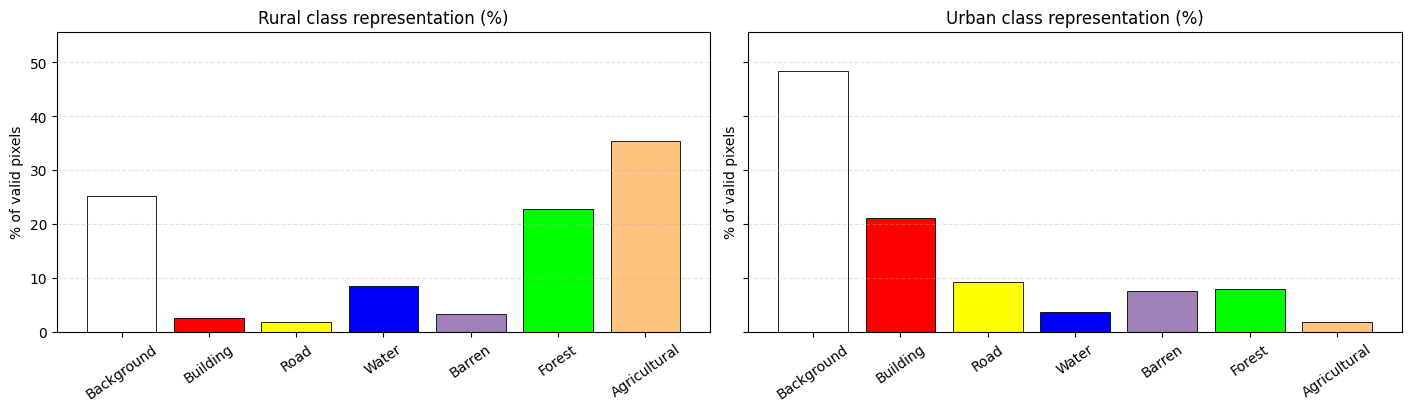

In [7]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Two bar charts (Rural vs Urban) showing class representation (%) with LoveDA colors.
base = Path(DATASET_DIR)
rural_dir = base / "Rural" / "masks_png"
urban_dir = base / "Urban" / "masks_png"

rural_pct, _ = compute_class_percentages_for_dir(rural_dir)
urban_pct, _ = compute_class_percentages_for_dir(urban_dir)

class_names = list(rural_pct.keys())
rural_vals = [rural_pct[c] for c in class_names]
urban_vals = [urban_pct.get(c, 0.0) for c in class_names]

# Use your defined class colors; fall back to gray if missing
bar_colors = [np.array(COLORS.get(c, (160, 160, 160))) / 255.0 for c in class_names]

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True, constrained_layout=True)

for ax, title, vals in zip(
    axes,
    ["Rural class representation (%)", "Urban class representation (%)"],
    [rural_vals, urban_vals],
):
    ax.bar(class_names, vals, color=bar_colors, edgecolor="black", linewidth=0.6)
    ax.set_title(title)
    ax.set_ylabel("% of valid pixels")
    ax.set_ylim(0, max(max(rural_vals), max(urban_vals)) * 1.15)
    ax.grid(axis="y", linestyle="--", alpha=0.35)
    ax.tick_params(axis="x", rotation=35)

plt.show()

/data/inr/llm/Datasets/LOVEDA/Train/Train


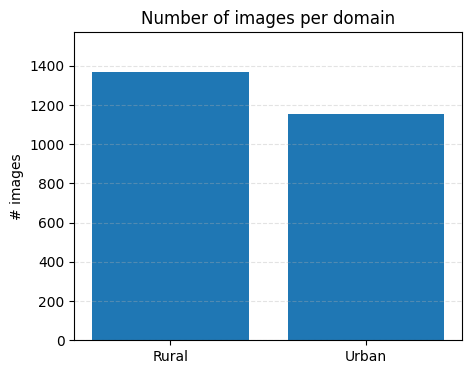

In [8]:
from pathlib import Path
import matplotlib.pyplot as plt

def count_domain_images(domain_root: Path) -> int:
    """Count image files for a domain (Rural/Urban) with a few common folder conventions."""
    candidates = [
        domain_root / "images_png",
        domain_root / "images",
        domain_root / "imgs",
        domain_root / "img",
    ]
    exts = {".png", ".jpg", ".jpeg", ".tif", ".tiff"}

    for d in candidates:
        if d.exists():
            return sum(1 for p in d.iterdir() if p.is_file() and p.suffix.lower() in exts)

    # Fallback: search recursively but avoid masks folders
    count = 0
    for p in domain_root.rglob("*"):
        if not p.is_file():
            continue
        if p.suffix.lower() not in exts:
            continue
        parts = {s.lower() for s in p.parts}
        if "masks" in parts or "masks_png" in parts or "mask" in parts:
            continue
        count += 1
    return count

DATASET_DIR2 = os.path.join(
    DATASET_DIR, "../../Test/Test"
)
print(os.path.abspath(DATASET_DIR))

base = Path(DATASET_DIR)
rural_root = base / "Rural"
urban_root = base / "Urban"

rural_n = count_domain_images(rural_root)
urban_n = count_domain_images(urban_root)

plt.figure(figsize=(5, 4))
plt.bar(["Rural", "Urban"], [rural_n, urban_n])
plt.title("Number of images per domain")
plt.ylabel("# images")
plt.ylim(0, max(rural_n, urban_n) * 1.15 if max(rural_n, urban_n) > 0 else 1)
plt.grid(axis="y", linestyle="--", alpha=0.35)
plt.show()

In [9]:
from pathlib import Path

# Average pixels per image, per class (Rural vs Urban) for Train masks.
base = Path(DATASET_DIR)
rural_dir = base / "Rural" / "masks_png"
urban_dir = base / "Urban" / "masks_png"

# Reuse the aggregator, but also get number of masks aggregated
rural_pct, rural_counts, rural_num = compute_class_percentages_for_dir(rural_dir, return_num_masks=True)
urban_pct, urban_counts, urban_num = compute_class_percentages_for_dir(urban_dir, return_num_masks=True)

rows = []
for cls in rural_counts.keys():
    rows.append({
        "Class": cls,
        "Rural_avg_pixels_per_image": rural_counts[cls] / max(rural_num, 1),
        "Urban_avg_pixels_per_image": urban_counts.get(cls, 0) / max(urban_num, 1),
        "Rural_num_masks": rural_num,
        "Urban_num_masks": urban_num,
    })

if pd is not None:
    df_avg = pd.DataFrame(rows)
    # nicer display
    df_avg["Rural_avg_pixels_per_image"] = df_avg["Rural_avg_pixels_per_image"].map(lambda x: round(float(x), 2))
    df_avg["Urban_avg_pixels_per_image"] = df_avg["Urban_avg_pixels_per_image"].map(lambda x: round(float(x), 2))
    display(df_avg)
else:
    for r in rows:
        print(
            f"{r['Class']:<14} | Rural avg px/img: {r['Rural_avg_pixels_per_image']:.2f} "
            f"(n={r['Rural_num_masks']}) | Urban avg px/img: {r['Urban_avg_pixels_per_image']:.2f} (n={r['Urban_num_masks']})"
        )

,Class,Rural_avg_pixels_per_image,Urban_avg_pixels_per_image,Rural_num_masks,Urban_num_masks
0,Background,257470.04,483567.69,1366,1156
1,Building,27007.05,211593.34,1366,1156
2,Road,19805.25,92617.53,1366,1156
3,Water,87609.56,37244.88,1366,1156
4,Barren,33280.07,75508.89,1366,1156
5,Forest,232602.53,79013.77,1366,1156
6,Agricultural,360613.61,18514.83,1366,1156


In [10]:
import os
import subprocess
from pathlib import Path

# Run sample_pair with CUDA_VISIBLE_DEVICES=7.
# This notebook may execute with CWD at the workspace root, so auto-detect the SyntheticGen repo root.

def _find_syntheticgen_root() -> Path:
    candidates = []
    cwd = Path(os.getcwd()).resolve()
    candidates.append(cwd)
    candidates.append(cwd / "SyntheticGen")
    candidates.extend(list(cwd.parents))
    candidates.extend([p / "SyntheticGen" for p in cwd.parents])

    for base in candidates:
        script = base / "src" / "scripts" / "sample_pair.py"
        cfg = base / "configs" / "sample_pair_ckpt40000_building0.4.yaml"
        if script.exists() and cfg.exists():
            return base
    raise FileNotFoundError(
        "Could not find SyntheticGen repo root containing src/scripts/sample_pair.py and the config YAML. "
        f"Tried starting from: {cwd}"
    )

repo_root = _find_syntheticgen_root()
script = repo_root / "src" / "scripts" / "sample_pair.py"
config = repo_root / "configs" / "sample_pair_ckpt40000_building0.4.yaml"

env = os.environ.copy()
env["CUDA_VISIBLE_DEVICES"] = "7"

cmd = ["python3", str(script), "--config", str(config)]
print("Working dir:", repo_root)
print("Running:", " ".join(cmd))

result = subprocess.run(cmd, cwd=str(repo_root), env=env, text=True, capture_output=True)
print(result.stdout)
if result.returncode != 0:
    print(result.stderr)
    raise RuntimeError(f"Command failed with exit code {result.returncode}")

Working dir: /data/inr/llm/DIFF_CD/Diffusor/SyntheticGen
Running: python3 /data/inr/llm/DIFF_CD/Diffusor/SyntheticGen/src/scripts/sample_pair.py --config /data/inr/llm/DIFF_CD/Diffusor/SyntheticGen/configs/sample_pair_ckpt40000_building0.4.yaml



/home/nvidia/.local/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.6.2) or chardet (None)/charset_normalizer (3.4.4) doesn't match a supported version!
  warnings.warn(
INFO - Resolved layout checkpoint to: /data/inr/llm/DIFF_CD/Diffusor/outputsV3/layout_d3pm_masked_sparse_80k_domain_cond/checkpoint-79000
INFO - Inferred --layout_size=256 from --image_size=1024 (override with --layout_size).
`torch_dtype` is deprecated! Use `dtype` instead!
Traceback (most recent call last):
  File "/data/inr/llm/DIFF_CD/Diffusor/SyntheticGen/src/scripts/sample_pair.py", line 1186, in <module>
    main()
  File "/data/inr/llm/DIFF_CD/Diffusor/SyntheticGen/src/scripts/sample_pair.py", line 1137, in main
    images = _vae_decode(vae, latents / vae.config.scaling_factor)
  File "/data/inr/llm/DIFF_CD/Diffusor/SyntheticGen/src/scripts/sample_pair.py", line 390, in _vae_decode
    decoded = vae.decode(latents)
  File "/data/inr/llm/DIFF_CD/Diffusor/diffusers/sr

RuntimeError: Command failed with exit code 1